# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

# Data management packages
from sklearn.model_selection import train_test_split

# Training model packages
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation packages
from sklearn.metrics import classification_report, confusion_matrix

# Data

### Data Downloads and Imports

In [ ]:
class Data:
  def __init__(self):
    self.data_frames = {}
    self.df = None
    self.train = None
    self.test = None

  def download(self):
    !gdown 11NUjXNzuFnBd0MShJYq-RlrFeepMHUrA
    !gdown 1WUNRZJgU0f5NaC-6Z0n_mMvt6P9yNV1U

    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").date()
    xmr_hash = pd.read_csv("./XMR_hash.csv", index_col=0, parse_dates=["time"], date_parser=date_parser)
    self.data_frames['xmr_hash'] = xmr_hash

    xmr_difficulty = pd.read_csv("./XMR_difficulty.csv", index_col=0, parse_dates=["time"], date_parser=date_parser)
    self.data_frames['xmr_difficulty'] = xmr_difficulty

    gold = yf.download(tickers = "GC=F",
                        period = "max",
                        interval = "1d").reset_index()
    gold = gold.rename(columns={'Open': 'gold_open', 'High': 'gold_high', 'Low': 'gold_low', 'Close': 'gold_close', 'Adj Close': 'gold_adj_close', 'Volume': 'gold_volume'})
    self.data_frames['gold'] = gold

    euro_usd = yf.download(tickers = "EURUSD=X",
                        period = "max",
                        interval = "1d").reset_index()
    euro_usd = euro_usd.rename(columns={'Open': 'euro_usd_open', 'High': 'euro_usd_high', 'Low': 'euro_usd_low', 'Close': 'euro_usd_close', 'Adj Close': 'euro_usd_adj_close', 'Volume': 'euro_usd_volume'})
    self.data_frames['euro_usd'] = euro_usd

    sp500 = yf.download(tickers = "^GSPC",
                        period = "max",
                        interval = "1d").reset_index()
    sp500 = sp500.rename(columns={'Open': 'sp500_open', 'High': 'sp500_high', 'Low': 'sp500_low', 'Close': 'sp500_close', 'Adj Close': 'sp500_adj_close', 'Volume': 'sp500_volume'})
    self.data_frames['sp500'] = sp500

    xmr = yf.download(tickers = "XMR-USD",
                        period = "max",
                      interval = "1d").reset_index()
    self.data_frames['xmr'] = xmr

  def available_data_frames(self):
    print('Available DataFrames: ')
    for data_frame in self.data_frames:
      print(data_frame)

  def merge_all(self):
    if len(self.data_frames) == 0:
      raise Exception('Please Download the Data First.')

    self.df = self.data_frames['xmr'].merge(self.data_frames['gold'], on='Date', how='left').merge(self.data_frames['euro_usd'], on='Date', how='left').merge(self.data_frames['sp500'], on='Date', how='left')
    self.df = self.data_frames['xmr_hash'].sort_values(by=["time", "time_stamp"]).drop_duplicates(subset=["time"], keep="last").merge(self.df, left_on="time", right_on="Date")
    self.df = self.data_frames['xmr_difficulty'].sort_values(by=["time", "time_stamp"]).drop_duplicates(subset=["time"], keep="last").merge(self.df, on="time")

  def describe_shapes(self):
    if self.df is None:
      raise Exception('Please Download and Merge All Data First.')

    print(f'Data has {self.df.shape[0]} records and {self.df.shape[1]} features.')

    if self.train is not None:
      print(f'Train has {self.train.shape[0]} records and {self.train.shape[1]} features.')

    if self.test is not None:
      print(f'Test has {self.test.shape[0]} records and {self.test.shape[1]} features.')


  def label_data(self):
    if self.df is None:
      raise Exception('Please Download and Merge All Data First.')

    if 'price_increase' not in self.df.columns:
      self.df.loc[0, "price_increase"] = 0
      for i in range(1, len(self.df)):
        self.df.loc[i, "price_increase"] = 1 if self.df.loc[i-1, "Close"] < self.df.loc[i, "Close"] else 0
    else:
      print('Already Labeled.')

  def handle_missing(self):
    if self.df is None:
      raise Exception('Please Download and Merge All Data First.')

    for data in ['gold', 'euro_usd', 'sp500']:
      self.df[f'{data}_open'].fillna(0 , inplace = True)
      for i in range(len(self.df)) :
        if self.df.loc[i, f'{data}_open'] == 0 and i != self.df.shape[0] - 1:
          self.df.loc[i, f'{data}_open'] = self.df.loc[i-1, f'{data}_close']
          self.df.loc[i, f'{data}_high'] = self.df.loc[i-1, f'{data}_close']
          self.df.loc[i, f'{data}_low'] = self.df.loc[i-1, f'{data}_close']
          self.df.loc[i, f'{data}_close'] = self.df.loc[i+1, f'{data}_open']
          self.df.loc[i, f'{data}_adj_close'] = self.df.loc[i+1, f'{data}_open']
          self.df.loc[i, f'{data}_volume'] = self.df.loc[i-1, f'{data}_volume']
        elif self.df.loc[i , f'{data}_open'] == 0 and i != 0:
          self.df.loc[i, f'{data}_open'] = self.df.loc[i-1, f'{data}_close']
          self.df.loc[i, f'{data}_high'] = self.df.loc[i-1, f'{data}_close']
          self.df.loc[i, f'{data}_low'] = self.df.loc[i-1, f'{data}_close']
          self.df.loc[i, f'{data}_close'] = self.df.loc[i-1, f'{data}_close']
          self.df.loc[i, f'{data}_adj_close'] = self.df.loc[i-1, f'{data}_close']
          self.df.loc[i, f'{data}_volume'] = self.df.loc[i-1, f'{data}_volume']
        elif self.df.loc[i , f'{data}_open'] == 0 and i == 0:
          self.df.loc[i, f'{data}_open'] = self.df.loc[i+1, f'{data}_open']
          self.df.loc[i, f'{data}_high'] = self.df.loc[i+1, f'{data}_open']
          self.df.loc[i, f'{data}_low'] = self.df.loc[i+1, f'{data}_open']
          self.df.loc[i, f'{data}_close'] = self.df.loc[i+1, f'{data}_open']
          self.df.loc[i, f'{data}_adj_close'] = self.df.loc[i+1, f'{data}_open']
          self.df.loc[i, f'{data}_volume'] = self.df.loc[i+1, f'{data}_volume']

  def split(self, test_date_range):
    self.test = self.df[self.df['Date'].isin(test_date_range)]
    self.train = self.df.drop(index=self.test.index)
    self.X = self.train.drop(columns = [ 'time_stamp_x', 'time_stamp_y', 'time', 'Date', 'price_increase'])
    self.y = self.train['price_increase']
    self.X_train, self.X_validation, self.y_train, self.y_validation = train_test_split(self.X, self.y , test_size = 0.25, random_state=42)
    self.X_test = self.test.drop(columns = [ 'time_stamp_x', 'time_stamp_y', 'time', 'Date', 'price_increase'])
    self.y_test = self.test['price_increase']



In [ ]:
data = Data()
data.download()

Downloading...
From: https://drive.google.com/uc?id=11NUjXNzuFnBd0MShJYq-RlrFeepMHUrA
To: /content/XMR_hash.csv
100% 181k/181k [00:00<00:00, 64.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WUNRZJgU0f5NaC-6Z0n_mMvt6P9yNV1U
To: /content/XMR_difficulty.csv
100% 213k/213k [00:00<00:00, 89.4MB/s]
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.available_data_frames()

Available DataFrames: 
xmr_hash
xmr_difficulty
gold
euro_usd
sp500
xmr


In [ ]:
data.merge_all()
data.label_data()

### Number of Records and Features

### First Glance at Data

In [ ]:
data.df.head()

,time_stamp_x,difficulty,time,time_stamp_y,hash,Date,Open,High,Low,Close,...,euro_usd_close,euro_usd_adj_close,euro_usd_volume,sp500_open,sp500_high,sp500_low,sp500_close,sp500_adj_close,sp500_volume,price_increase
0,1510185600000,2.806786e+10,2017-11-09,1.510190e+12,233898872.2,2017-11-09,112.531998,123.404999,112.219002,120.779999,...,1.159689,1.159689,0.0,2584.000000,2586.500000,2566.330078,2584.620117,2584.620117,3.844100e+09,0.0
1,1510272000000,2.805339e+10,2017-11-10,1.510270e+12,233778227.0,2017-11-10,121.344002,121.665001,101.757004,105.585999,...,1.164687,1.164687,0.0,2580.179932,2583.810059,2575.570068,2582.300049,2582.300049,3.489740e+09,0.0
2,1510358400000,2.805339e+10,2017-11-11,1.510360e+12,233778227.0,2017-11-11,105.750000,127.106003,103.877998,119.615997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1510444800000,2.805339e+10,2017-11-12,1.510440e+12,233778227.0,2017-11-12,119.597000,133.675003,110.617996,123.856003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1510531200000,2.805339e+10,2017-11-13,1.510530e+12,233778227.0,2017-11-13,128.960007,136.528000,120.921997,123.402000,...,1.166113,1.166113,0.0,2576.530029,2587.659912,2574.479980,2584.840088,2584.840088,3.405200e+09,0.0


In [ ]:
data.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 0 to 2150
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   time_stamp_x        2151 non-null   int64         
 1   difficulty          2151 non-null   float64       
 2   time                2151 non-null   datetime64[ns]
 3   time_stamp_y        2151 non-null   float64       
 4   hash                2151 non-null   float64       
 5   Date                2151 non-null   datetime64[ns]
 6   Open                2151 non-null   float64       
 7   High                2151 non-null   float64       
 8   Low                 2151 non-null   float64       
 9   Close               2151 non-null   float64       
 10  Adj Close           2151 non-null   float64       
 11  Volume              2151 non-null   int64         
 12  gold_open           1479 non-null   float64       
 13  gold_high           1479 non-null   float64     

In [ ]:
data.df.describe()

,time_stamp_x,difficulty,time_stamp_y,hash,Open,High,Low,Close,Adj Close,Volume,...,euro_usd_close,euro_usd_adj_close,euro_usd_volume,sp500_open,sp500_high,sp500_low,sp500_close,sp500_adj_close,sp500_volume,price_increase
count,2.151000e+03,2.151000e+03,2.151000e+03,2.151000e+03,2151.000000,2151.000000,2151.000000,2151.000000,2151.000000,2.151000e+03,...,1532.000000,1532.000000,1532.0,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1.480000e+03,2151.000000
mean,1.603820e+12,1.976282e+11,1.603820e+12,1.646751e+09,149.291153,154.618419,143.512988,149.273027,149.273027,2.441164e+08,...,1.129818,1.129818,0.0,3533.721524,3554.844439,3510.881040,3534.059304,3534.059304,4.191229e+09,0.523942
std,5.370437e+10,1.208999e+11,5.370437e+10,1.007571e+09,80.829475,85.220590,75.850084,80.752951,80.752951,1.002074e+09,...,0.058968,0.058968,0.0,685.307465,688.673792,682.205665,685.612934,685.612934,1.046885e+09,0.499543
min,1.510186e+12,2.805339e+10,1.510190e+12,2.337782e+08,33.084614,36.645374,26.703888,33.010323,33.010323,1.016030e+07,...,0.959619,0.959619,0.0,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,1.296530e+09,0.000000
25%,1.557403e+12,6.213049e+10,1.557405e+12,5.177541e+08,83.407471,86.435257,80.025642,83.402840,83.402840,6.390984e+07,...,1.091709,1.091709,0.0,2862.912598,2882.262573,2853.010010,2868.139954,2868.139954,3.533445e+09,0.000000
50%,1.603843e+12,1.908854e+11,1.603840e+12,1.590711e+09,143.735535,146.831573,140.967117,143.886154,143.886154,1.012480e+08,...,1.129701,1.129701,0.0,3497.354980,3518.670044,3482.435059,3494.489990,3494.489990,3.964315e+09,1.000000
75%,1.650283e+12,3.151443e+11,1.650285e+12,2.626203e+09,189.852280,198.894325,182.432182,189.754730,189.754730,1.893480e+08,...,1.176834,1.176834,0.0,4155.065063,4175.400024,4126.080200,4155.499878,4155.499878,4.579050e+09,1.000000
max,1.696748e+12,4.155535e+11,1.696760e+12,3.462946e+09,483.709991,517.620239,453.390991,483.583618,483.583618,2.895912e+10,...,1.251001,1.251001,0.0,4804.509766,4818.620117,4780.040039,4796.560059,4796.560059,9.976520e+09,1.000000


### Missing Values

In [ ]:
data.df.isna().sum()

time_stamp_x            0
difficulty              0
time                    0
time_stamp_y            0
hash                    0
Date                    0
Open                    0
High                    0
Low                     0
Close                   0
Adj Close               0
Volume                  0
gold_open             672
gold_high             672
gold_low              672
gold_close            672
gold_adj_close        672
gold_volume           672
euro_usd_open         619
euro_usd_high         619
euro_usd_low          619
euro_usd_close        619
euro_usd_adj_close    619
euro_usd_volume       619
sp500_open            671
sp500_high            671
sp500_low             671
sp500_close           671
sp500_adj_close       671
sp500_volume          671
price_increase          0
dtype: int64

#### Handling Missing Values

In [ ]:
data.handle_missing()
data.df.isna().sum()

time_stamp_x          0
difficulty            0
time                  0
time_stamp_y          0
hash                  0
Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
gold_open             0
gold_high             0
gold_low              0
gold_close            0
gold_adj_close        0
gold_volume           0
euro_usd_open         0
euro_usd_high         0
euro_usd_low          0
euro_usd_close        0
euro_usd_adj_close    0
euro_usd_volume       0
sp500_open            0
sp500_high            0
sp500_low             0
sp500_close           0
sp500_adj_close       0
sp500_volume          0
price_increase        0
dtype: int64

### Splitting Data into Train, Validation and Test

In [ ]:
data.split(test_date_range=pd.date_range(start='2023-09-08', end='2023-10-07', freq='D'))

In [ ]:
data.describe_shapes()

Data has 2151 records and 31 features.
Train has 2121 records and 31 features.
Test has 30 records and 31 features.


# Experimenting with Different Machine Learning Models

In [ ]:
verbose = 10
scores = []

In [ ]:
class Model:
  def __init__(self, model, parameters, name, cv, verbose):
    self.model = model
    self.parameters = parameters
    self.name = name
    self.cv = cv
    self.verbose = verbose
    self.scores = {}
    self.pipe_line = Pipeline([
          ('scaler' , StandardScaler()),
          (f'{self.name}', GridSearchCV(self.model, param_grid=self.parameters, cv=self.cv, refit=True, verbose=self.verbose))
        ])

  def tuner(self, X, y):
    self.pipe_line = self.pipe_line.fit(X, y)
    self.best_estimator_ = self.pipe_line[f'{self.name}'].best_estimator_
    self.best_score_ = self.pipe_line[f'{self.name}'].best_score_

  def predictor(self, X):
    y_pred = self.pipe_line.predict(X)
    return y_pred

  def classification_report(self, X, y, output_dict):
    y_pred = self.predictor(X)
    return classification_report(y, y_pred, output_dict=output_dict)

## Stochastic Gradient Descent

**Stochastic Gradient Descent** (SGD) is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

### HyperParameter Tuning

In [ ]:
# Random Seed 7 gives 100 score

sgd_param_grid = [
    {
        'loss': ['hinge', 'log_loss'],
        'penalty':['l1', 'l2', 'elasticnet', None],
        'alpha': [1e-5, 1e-4 ,1e-3 , 1e-2, 1e-1, 1],
        'max_iter': [int(1e6)],
        'tol': [1e-6, 1e-5, 1e-4]
    },
    {
        'loss': ['perceptron'],
        'penalty':['l1', 'l2', 'elasticnet'],
        'alpha': [1e-4 ,1e-3 , 1e-2, 1e-1],
        'max_iter': [int(1e6)],
        'tol': [1e-6, 1e-5],
        'learning_rate': ['optimal', 'invscaling', 'constant', 'adaptive'],
        'eta0': [1e-2, 1e-3, 1e-4, 1e-5]
    }
]

sgd = Model(model=SGDClassifier(random_state=7), parameters=sgd_param_grid, name='sgdc', cv=5, verbose=verbose)
sgd.tuner(data.X_train, data.y_train)

### Model Evaluation

In [ ]:
print(f"Best SGD Parameters are: {sgd.best_estimator_}")

Best SGD Parameters are: SGDClassifier(alpha=0.01, eta0=0.001, learning_rate='adaptive',
              loss='perceptron', max_iter=1000000, penalty='elasticnet',
              random_state=7, tol=1e-06)


In [ ]:


sgd_scores = {
    'name': 'Stochastic Gradient Descent',
    'gridsearch_best_score': sgd.best_score_,
    'classification_reports':{
    'train': sgd.classification_report(data.X_train, data.y_train, output_dict=True),
    'validation': sgd.classification_report(data.X_validation, data.y_validation, output_dict=True),
    'test': sgd.classification_report(data.X_test, data.y_test, output_dict=True),
    },
    'confusion_matrices': {
        'train': confusion_matrix(data.y_train, sgd.predictor(data.X_train)),
        'validation': confusion_matrix(data.y_validation, sgd.predictor(data.X_validation)),
        'test': confusion_matrix(data.y_test, sgd.predictor(data.X_test))
    }
}

scores.append(sgd_scores)

#### GridSearch Best Score

In [ ]:
print(sgd_scores['gridsearch_best_score'])

0.9886792452830189


#### Classification Reports

##### Train Data

In [ ]:
pd.DataFrame(sgd_scores['classification_reports']['train']).T

,precision,recall,f1-score,support
0.0,0.992136,0.990838,0.991487,764.000000
1.0,0.991536,0.992736,0.992136,826.000000
accuracy,0.991824,0.991824,0.991824,0.991824
macro avg,0.991836,0.991787,0.991811,1590.000000
weighted avg,0.991824,0.991824,0.991824,1590.000000


##### Validation Data

In [ ]:
pd.DataFrame(sgd_scores['classification_reports']['validation']).T

,precision,recall,f1-score,support
0.0,0.995984,1.000000,0.997988,248.000000
1.0,1.000000,0.996466,0.998230,283.000000
accuracy,0.998117,0.998117,0.998117,0.998117
macro avg,0.997992,0.998233,0.998109,531.000000
weighted avg,0.998124,0.998117,0.998117,531.000000


##### Test Data

In [ ]:
pd.DataFrame(sgd_scores['classification_reports']['test']).T

,precision,recall,f1-score,support
0.0,1.0,1.0,1.0,12.0
1.0,1.0,1.0,1.0,18.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,30.0
weighted avg,1.0,1.0,1.0,30.0


## Support Vector Machines Classifier

**Support vector machines** (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The **advantages** of support vector machines are:

- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The **disadvantages** of support vector machines include:

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

### HyperParameter Tuning

In [ ]:
svc_param_grid = [
    {'kernel':['linear'] , 'C':[1e-3 , 1e-2 , 1e-1 , 1 , 10 , 1e2 ,1e3 , 1e4] , 'tol': [1e-2 , 1e-3 , 1e-4 , 1e-5]},
    {'kernel': ['rbf'] , 'C':[1 , 10 , 1e2 ,1e3 ,1e4 , 1e5] , 'tol': [1e-1 , 1e-2 , 1e-3 , 1e-4 ,1e-5 , 'scale']},
    {'kernel': ['poly'] , 'C':[1 , 10 ,100 ,1000 ,10000] , 'tol':[1e-2 ,1e-3 , 1e-4 , 1e-5 ,'scale'] , 'degree': [2 , 3, 4]}
]

svc = Model(model=SVC(), parameters=svc_param_grid, name='svc', cv=5, verbose=verbose)
svc.tuner(data.X_train, data.y_train)

### Model Evaluation

In [ ]:
print(f"Best SVC Parameters are: {svc.best_estimator_}")

Best SVC Parameters are: SVC(C=10000.0, kernel='linear', tol=0.01)


In [ ]:
svc_scores = {
    'name': 'Support Vector Machine',
    'gridsearch_best_score': svc.best_score_,
    'classification_reports':{
    'train': svc.classification_report(data.X_train, data.y_train, output_dict=True),
    'validation': svc.classification_report(data.X_validation, data.y_validation, output_dict=True),
    'test': svc.classification_report(data.X_test, data.y_test, output_dict=True),
    },
    'confusion_matrices': {
        'train': confusion_matrix(data.y_train, svc.predictor(data.X_train)),
        'validation': confusion_matrix(data.y_validation, svc.predictor(data.X_validation)),
        'test': confusion_matrix(data.y_test, svc.predictor(data.X_test))
    }
}

scores.append(svc_scores)

#### GridSearch Best Score

In [ ]:
print(svc_scores['gridsearch_best_score'])

0.9754716981132076


#### Classification Reports

##### Train Data

In [ ]:
pd.DataFrame(svc_scores['classification_reports']['train']).T

,precision,recall,f1-score,support
0.0,0.988173,0.984293,0.986230,764.000000
1.0,0.985525,0.989104,0.987311,826.000000
accuracy,0.986792,0.986792,0.986792,0.986792
macro avg,0.986849,0.986699,0.986770,1590.000000
weighted avg,0.986797,0.986792,0.986791,1590.000000


##### Validation Date

In [ ]:
pd.DataFrame(svc_scores['classification_reports']['validation']).T

,precision,recall,f1-score,support
0.0,0.991903,0.987903,0.989899,248.000000
1.0,0.989437,0.992933,0.991182,283.000000
accuracy,0.990584,0.990584,0.990584,0.990584
macro avg,0.990670,0.990418,0.990540,531.000000
weighted avg,0.990588,0.990584,0.990583,531.000000


##### Test Data

In [ ]:
pd.DataFrame(svc_scores['classification_reports']['test']).T

,precision,recall,f1-score,support
0.0,1.000000,0.916667,0.956522,12.000000
1.0,0.947368,1.000000,0.972973,18.000000
accuracy,0.966667,0.966667,0.966667,0.966667
macro avg,0.973684,0.958333,0.964747,30.000000
weighted avg,0.968421,0.966667,0.966392,30.000000


## K-Nearest Neighbors Classifier

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

### HyperParameter Tuning

In [ ]:
knn_param_grid = [
    {'n_neighbors':[3, 4, 5, 7, 10, 15] ,
     'weights': ['uniform', 'distance'],
     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
     'leaf_size': [15, 30, 45, 60, 100],
     'p': [1, 2, 3]
     }
]

knn = Model(model=KNeighborsClassifier(), parameters=knn_param_grid, name='knn', cv=5, verbose=verbose)
knn.tuner(data.X_train, data.y_train)

### Model Evaluation

In [ ]:
print(f"Best KNN Parameters are: {knn.best_estimator_}")

Best KNN Parameters are: KNeighborsClassifier(leaf_size=15, n_neighbors=4, p=3, weights='distance')


In [ ]:
knn_scores = {
    'name': 'K-Nearest Neighbors',
    'gridsearch_best_score': knn.best_score_,
    'classification_reports':{
    'train': knn.classification_report(data.X_train, data.y_train, output_dict=True),
    'validation': knn.classification_report(data.X_validation, data.y_validation, output_dict=True),
    'test': knn.classification_report(data.X_test, data.y_test, output_dict=True),
    },
    'confusion_matrices': {
        'train': confusion_matrix(data.y_train, knn.predictor(data.X_train)),
        'validation': confusion_matrix(data.y_validation, knn.predictor(data.X_validation)),
        'test': confusion_matrix(data.y_test, knn.predictor(data.X_test))
    }
}

scores.append(knn_scores)

#### GridSearch Best Score

In [ ]:
print(knn_scores['gridsearch_best_score'])

0.5264150943396226


#### Classification Reports

##### Train Data

In [ ]:
pd.DataFrame(knn_scores['classification_reports']['train']).T

,precision,recall,f1-score,support
0.0,1.0,1.0,1.0,764.0
1.0,1.0,1.0,1.0,826.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1590.0
weighted avg,1.0,1.0,1.0,1590.0


##### Validation Data

In [ ]:
pd.DataFrame(knn_scores['classification_reports']['validation']).T

,precision,recall,f1-score,support
0.0,0.530120,0.532258,0.531187,248.000000
1.0,0.588652,0.586572,0.587611,283.000000
accuracy,0.561205,0.561205,0.561205,0.561205
macro avg,0.559386,0.559415,0.559399,531.000000
weighted avg,0.561316,0.561205,0.561258,531.000000


##### Test Data

In [ ]:
pd.DataFrame(knn_scores['classification_reports']['test']).T

,precision,recall,f1-score,support
0.0,0.333333,0.333333,0.333333,12.000000
1.0,0.555556,0.555556,0.555556,18.000000
accuracy,0.466667,0.466667,0.466667,0.466667
macro avg,0.444444,0.444444,0.444444,30.000000
weighted avg,0.466667,0.466667,0.466667,30.000000


## Gradient Boost Classifier

Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions, see the seminal work of [Friedman2001]. GBDT is an excellent model for both regression and classification, in particular for tabular data.

### HyperParameter Tuning

In [ ]:
gbc_param_grid = [
    {
        'loss': ['log_loss', 'exponential'],
         'learning_rate': [1e-2, 1e-1, 1],
        'n_estimators': [1000, 10000],
         'criterion': ['friedman_mse', 'squarred_error'],
         'min_samples_split': [2],
         'min_samples_leaf': [1],
        'max_depth': [5, 7, 9],
        'max_depth': [7, 9, 15, 100],
         'max_features': [None, 'sqrt', 'log2']
     }
]

gbc = Model(model=GradientBoostingClassifier(), parameters=gbc_param_grid, name='gbc', cv=5, verbose=verbose)
gbc.tuner(data.X_train, data.y_train)

### Model Evaluation

In [ ]:
print(f"Best Gradient Boost Classifier Parameters are: {gbc.best_estimator_}")

Best Gradient Boost Classifier Parameters are: GradientBoostingClassifier(max_depth=9, n_estimators=10000)


In [ ]:
gbc_scores = {
    'name': 'Gradient Boost Classifier',
    'gridsearch_best_score': gbc.best_score_,
    'classification_reports':{
    'train': gbc.classification_report(data.X_train, data.y_train, output_dict=True),
    'validation': gbc.classification_report(data.X_validation, data.y_validation, output_dict=True),
    'test': gbc.classification_report(data.X_test, data.y_test, output_dict=True),
    },
    'confusion_matrices': {
        'train': confusion_matrix(data.y_train, gbc.predictor(data.X_train)),
        'validation': confusion_matrix(data.y_validation, gbc.predictor(data.X_validation)),
        'test': confusion_matrix(data.y_test, gbc.predictor(data.X_test))
    }
}

scores.append(gbc_scores)

#### GridSearch Best Score

In [ ]:
print(gbc_scores['gridsearch_best_score'])

0.8364779874213836


#### Classification Reports

##### Train Data

In [ ]:
pd.DataFrame(gbc_scores['classification_reports']['train']).T

,precision,recall,f1-score,support
0.0,1.0,1.0,1.0,764.0
1.0,1.0,1.0,1.0,826.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1590.0
weighted avg,1.0,1.0,1.0,1590.0


##### Validation Data

In [ ]:
pd.DataFrame(gbc_scores['classification_reports']['validation']).T

,precision,recall,f1-score,support
0.0,0.838583,0.858871,0.848606,248.000000
1.0,0.873646,0.855124,0.864286,283.000000
accuracy,0.856874,0.856874,0.856874,0.856874
macro avg,0.856114,0.856997,0.856446,531.000000
weighted avg,0.857270,0.856874,0.856962,531.000000


##### Test Data

In [ ]:
pd.DataFrame(gbc_scores['classification_reports']['test']).T

,precision,recall,f1-score,support
0.0,1.000,0.50,0.666667,12.0
1.0,0.750,1.00,0.857143,18.0
accuracy,0.800,0.80,0.800000,0.8
macro avg,0.875,0.75,0.761905,30.0
weighted avg,0.850,0.80,0.780952,30.0


## Random Forest Classifier

In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. (See the parameter tuning guidelines for more details).

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

### HyperParameter Tuning

In [ ]:
rfc_param_grid = [
    {
        'n_estimators': [10, 100, 250, 500],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'min_samples_split': [2, 3, 5]
    }
]

rfc = Model(model=RandomForestClassifier(), parameters=rfc_param_grid, name='rfc', cv=5, verbose=verbose)
rfc.tuner(data.X_train, data.y_train)

### Model Evaluation

In [ ]:
print(f"Best Random Forest Classifier Parameters are: {rfc.best_estimator_}")

Best Random Forest Classifier Parameters are: RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=250)


In [ ]:
rfc_scores = {
    'name': 'Random Forest Classifier',
    'gridsearch_best_score': rfc.best_score_,
    'classification_reports':{
    'train': rfc.classification_report(data.X_train, data.y_train, output_dict=True),
    'validation': rfc.classification_report(data.X_validation, data.y_validation, output_dict=True),
    'test': rfc.classification_report(data.X_test, data.y_test, output_dict=True),
    },
    'confusion_matrices': {
        'train': confusion_matrix(data.y_train, rfc.predictor(data.X_train)),
        'validation': confusion_matrix(data.y_validation, rfc.predictor(data.X_validation)),
        'test': confusion_matrix(data.y_test, rfc.predictor(data.X_test))
    }
}

scores.append(rfc_scores)

#### GridSearch Best Score

In [ ]:
print(rfc_scores['gridsearch_best_score'])

0.5729559748427673


#### Classification Reports

##### Train Data

In [ ]:
pd.DataFrame(rfc_scores['classification_reports']['train']).T

,precision,recall,f1-score,support
0.0,1.0,1.0,1.0,764.0
1.0,1.0,1.0,1.0,826.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1590.0
weighted avg,1.0,1.0,1.0,1590.0


##### Validation Data

In [ ]:
pd.DataFrame(rfc_scores['classification_reports']['validation']).T

,precision,recall,f1-score,support
0.0,0.590308,0.540323,0.564211,248.000000
1.0,0.625000,0.671378,0.647359,283.000000
accuracy,0.610169,0.610169,0.610169,0.610169
macro avg,0.607654,0.605850,0.605785,531.000000
weighted avg,0.608798,0.610169,0.608525,531.000000


##### Test Data

In [ ]:
pd.DataFrame(rfc_scores['classification_reports']['test']).T

,precision,recall,f1-score,support
0.0,0.666667,0.500000,0.571429,12.0
1.0,0.714286,0.833333,0.769231,18.0
accuracy,0.700000,0.700000,0.700000,0.7
macro avg,0.690476,0.666667,0.670330,30.0
weighted avg,0.695238,0.700000,0.690110,30.0


## Logistic Regression

The **logistic regression** is implemented in LogisticRegression. Despite its name, it is implemented as a linear model for classification rather than regression in terms of the scikit-learn/ML nomenclature. The logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

### HyperParameter Tuning

In [ ]:
lr_param_grid = [
    {'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'], 'penalty': ['l2', None], 'tol':[1e-4, 1e-5, 1e-7], 'C': [1e-3, 1e-2, 1e-1, 1, 10]},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'tol':[1e-4, 1e-5, 1e-7], 'C': [1e-3, 1e-2, 1e-1, 1, 10]},
    {'solver': ['saga'], 'penalty': ['elasticnet', 'l1', 'l2', None], 'tol':[1e-4, 1e-5, 1e-7], 'C': [1e-3, 1e-2, 1e-1, 1, 10]},
]

lr = Model(model=LogisticRegression(), parameters=lr_param_grid, name='lr', cv=5, verbose=verbose)
lr.tuner(data.X_train, data.y_train)

### Model Evaluation

In [ ]:
print(f"Best Logistic Regression Parameters are: {lr.best_estimator_}")

Best Logistic Regression Parameters are: LogisticRegression(C=1, penalty='l1', solver='liblinear')


In [ ]:
lr_scores = {
    'name': 'Logistic Regression',
    'gridsearch_best_score': lr.best_score_,
    'classification_reports':{
    'train': lr.classification_report(data.X_train, data.y_train, output_dict=True),
    'validation': lr.classification_report(data.X_validation, data.y_validation, output_dict=True),
    'test': lr.classification_report(data.X_test, data.y_test, output_dict=True),
    },
    'confusion_matrices': {
        'train': confusion_matrix(data.y_train, lr.predictor(data.X_train)),
        'validation': confusion_matrix(data.y_validation, lr.predictor(data.X_validation)),
        'test': confusion_matrix(data.y_test, lr.predictor(data.X_test))
    }
}

scores.append(lr_scores)

#### GridSearch Best Score

In [ ]:
print(lr_scores['gridsearch_best_score'])

0.9792452830188679


#### Classification Reports

##### Train Data

In [ ]:
pd.DataFrame(lr_scores['classification_reports']['train']).T

,precision,recall,f1-score,support
0.0,0.986755,0.975131,0.980908,764.000000
1.0,0.977246,0.987893,0.982541,826.000000
accuracy,0.981761,0.981761,0.981761,0.981761
macro avg,0.982000,0.981512,0.981725,1590.000000
weighted avg,0.981815,0.981761,0.981756,1590.000000


##### Validation Data

In [ ]:
pd.DataFrame(lr_scores['classification_reports']['validation']).T

,precision,recall,f1-score,support
0.0,0.995918,0.983871,0.989858,248.000000
1.0,0.986014,0.996466,0.991213,283.000000
accuracy,0.990584,0.990584,0.990584,0.990584
macro avg,0.990966,0.990169,0.990535,531.000000
weighted avg,0.990640,0.990584,0.990580,531.000000


##### Test Data

In [ ]:
pd.DataFrame(lr_scores['classification_reports']['test']).T

,precision,recall,f1-score,support
0.0,1.000000,0.833333,0.909091,12.000000
1.0,0.900000,1.000000,0.947368,18.000000
accuracy,0.933333,0.933333,0.933333,0.933333
macro avg,0.950000,0.916667,0.928230,30.000000
weighted avg,0.940000,0.933333,0.932057,30.000000


# Conclusions

## Best Model and Score

- **Best Model**: Stochastic Gradient Descent
- **Best Test Data f1-score**: 1.0

## Scores

### Classification Reports HeatMap

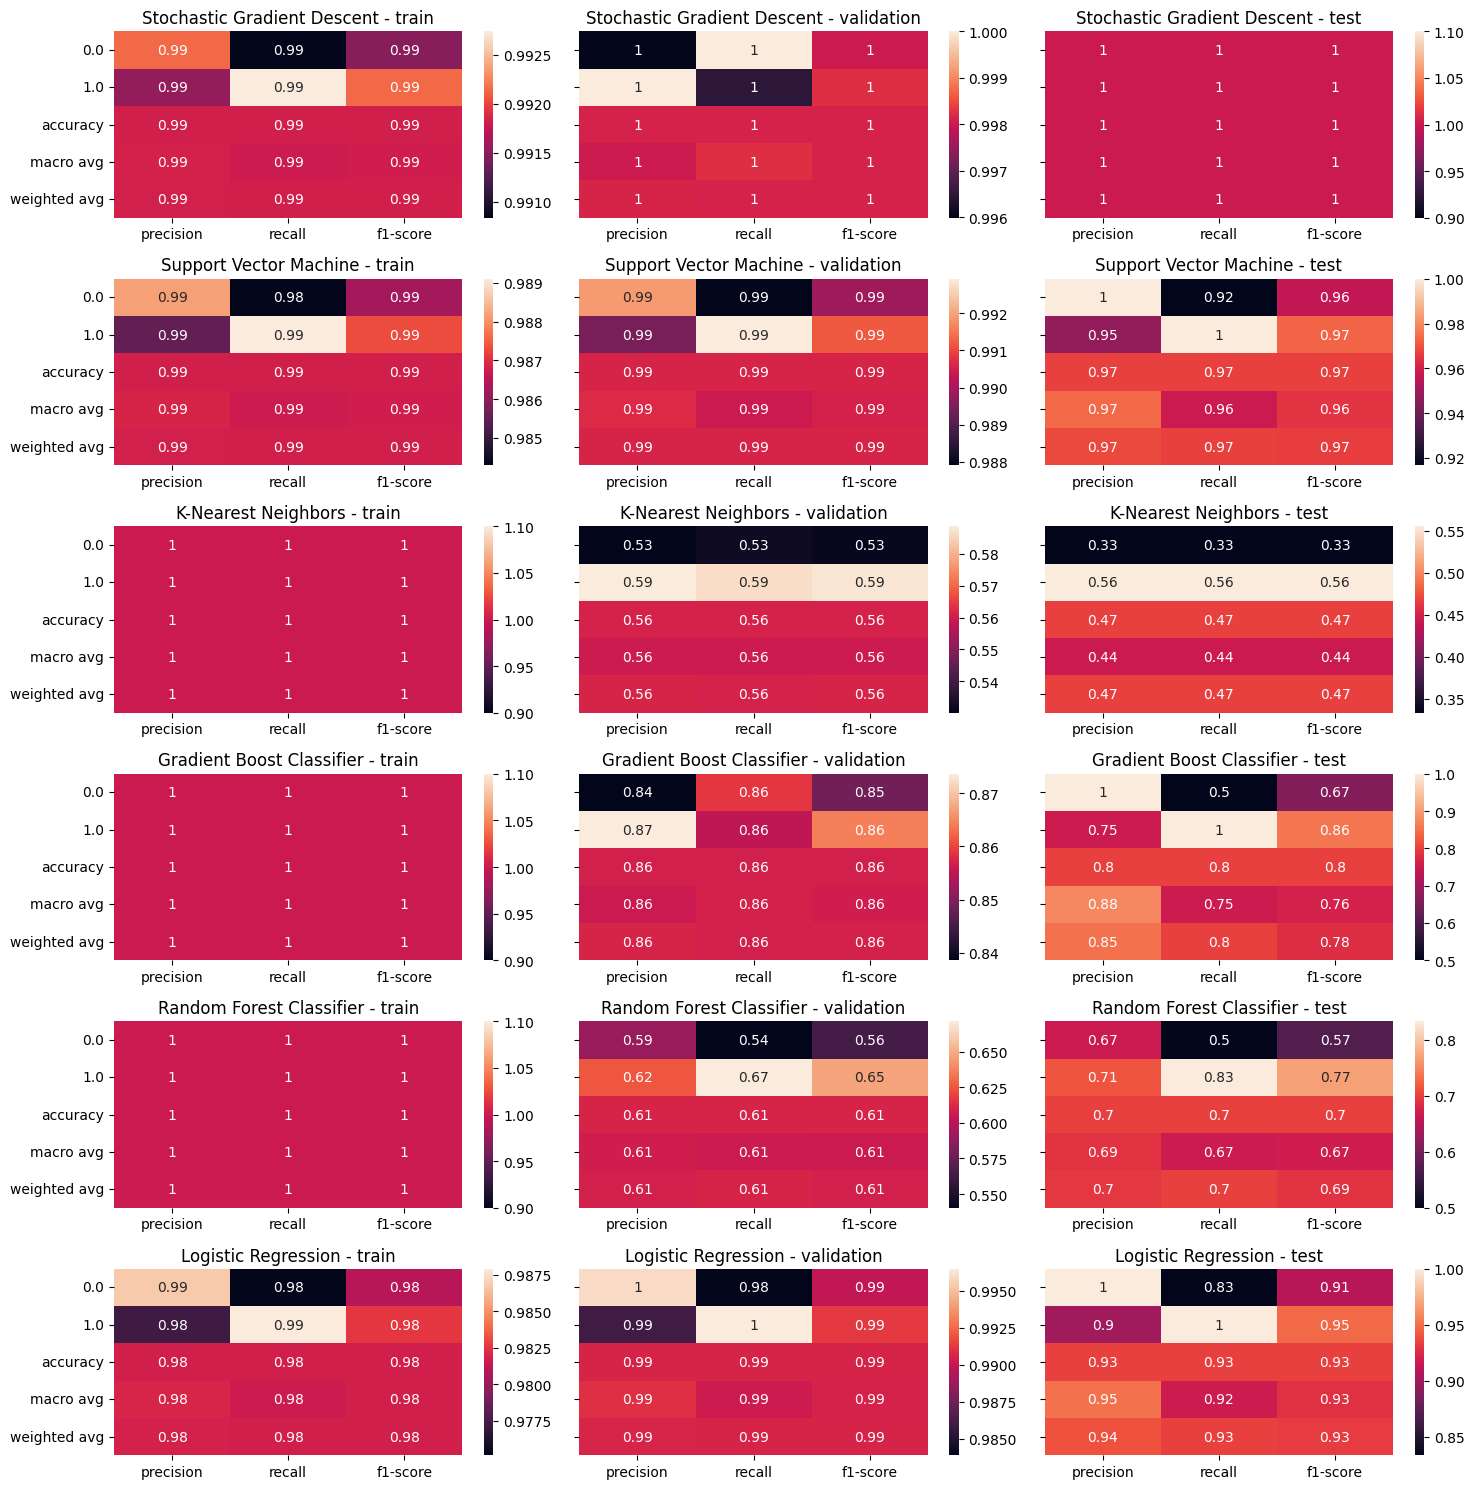

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15), sharey=True)

for i in range(6):
  m = 0
  for data_type in scores[i]['classification_reports']:
    crdf = pd.DataFrame(scores[i]['classification_reports'][data_type]).iloc[:-1, :].T
    sns.heatmap(crdf, ax=axes[i, m], annot=True)
    axes[i, m].set_title(f"{scores[i]['name']} - {data_type}")
    m = m+1

plt.tight_layout()

### Confusion Matrices

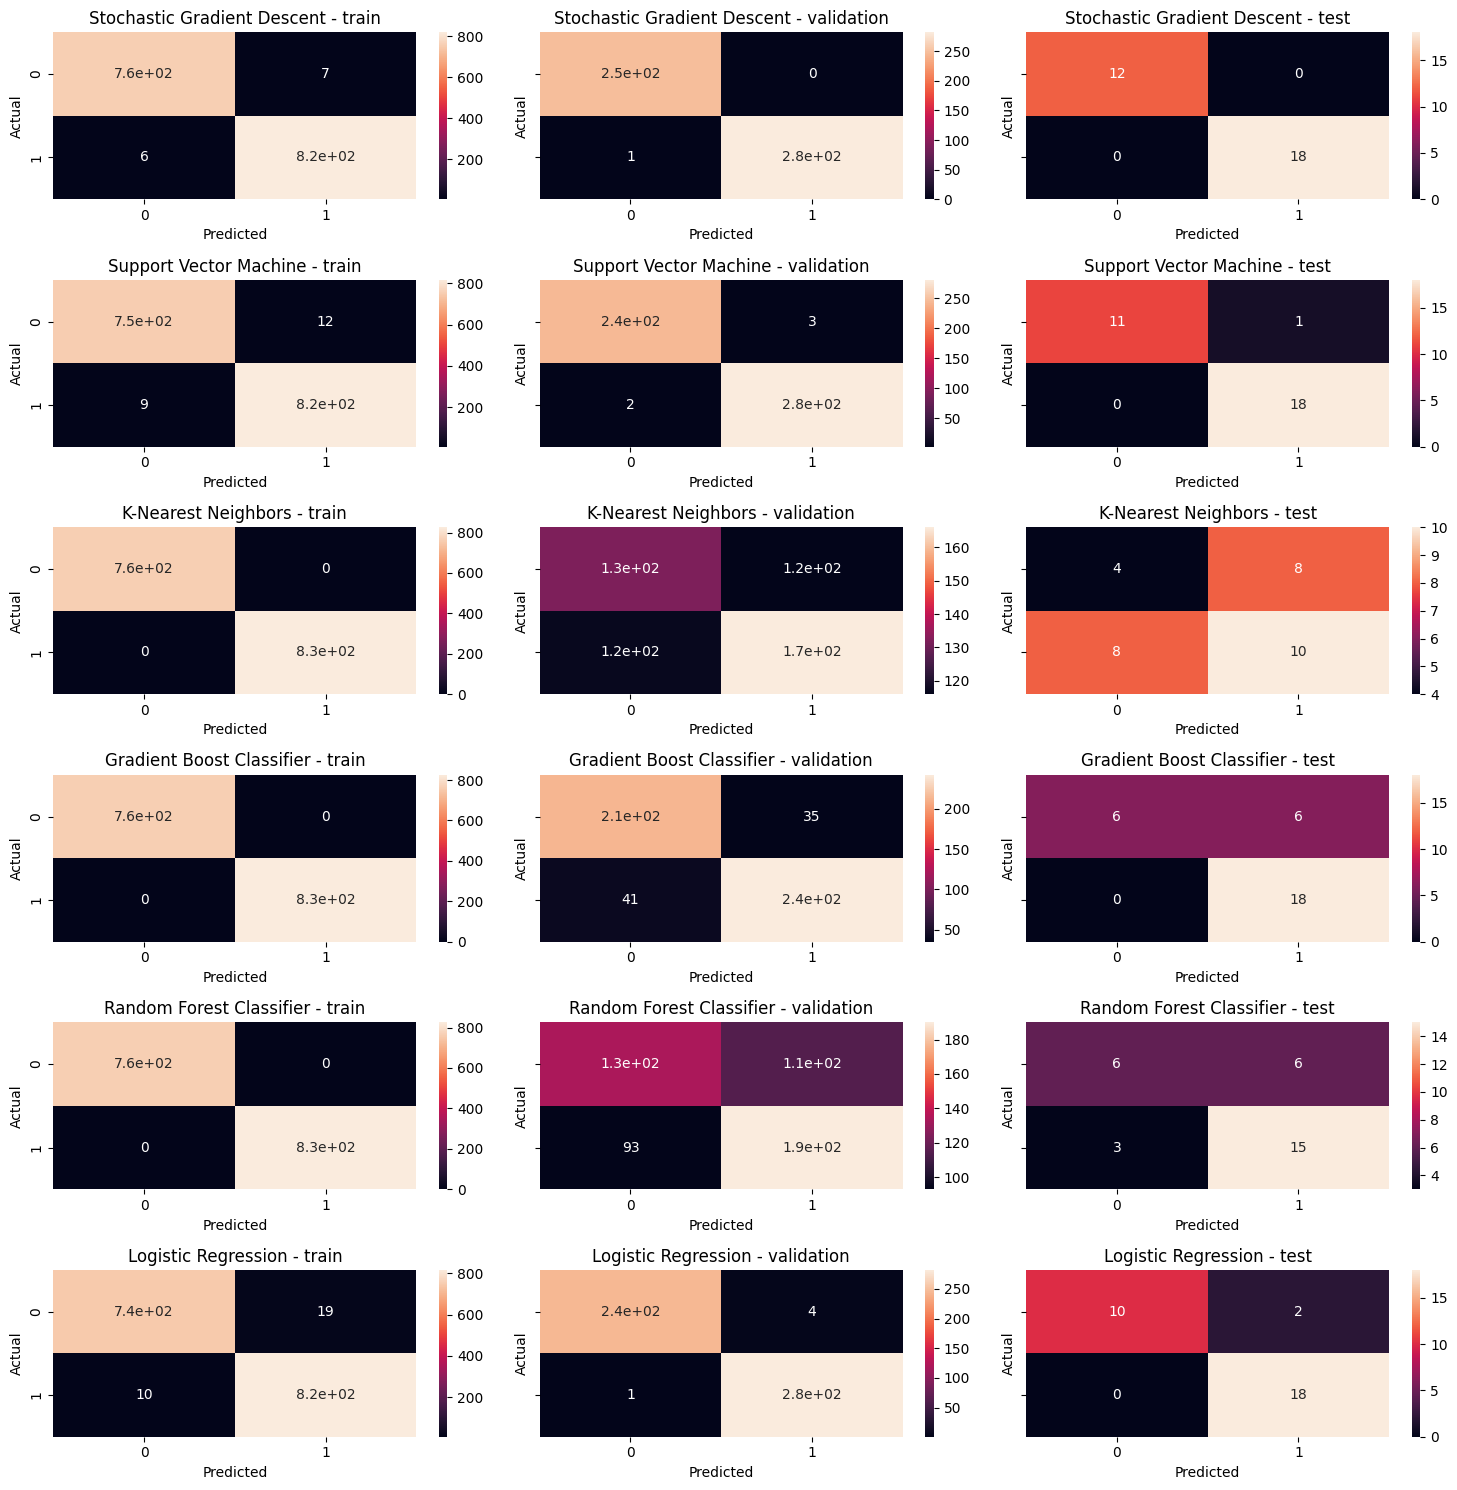

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15), sharey=True)

for i in range(6):
  m = 0
  for data_type in scores[i]['confusion_matrices']:
    crdf = pd.DataFrame(scores[i]['confusion_matrices'][data_type])
    crdf.index.name = 'Actual'
    crdf.columns.name = 'Predicted'
    sns.heatmap(crdf, ax=axes[i, m], annot=True)
    axes[i, m].set_title(f"{scores[i]['name']} - {data_type}")
    m = m+1

plt.tight_layout()